# ***BIG DATA FINAL PROJECT***

<h2>Classification of the reviews using the Naive Bayes classifier applying NLP techniques</h2>

<h2><b><i>Problem Statement:</i></b></h2>

<p>In the internet world today, it is easy to get feedbacks for any product or a service through reviews and ratings rather than relying on the old school method of getting feedbacks by asking the custmers to fill out forms. In this project, we have taken the Kaggle dataset that contains the reviews for around 13,000 products sold through Amazon.</p><p>Our objective is to classify the reviews as either positive or negative(good or bad). This will benefit the sellers in a way that they can study about the market for their products and also Amazon to assess every seller and reform the business association.</p><p>We are going to use the Naive Bayes classifier to identify the type of review after cleaning the data using NLP techniques</p>

<h3> Import and create a spark session </h3>

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('Project').getOrCreate()

<h4>Read the Reviews.txt file as a Spark DataFrame</h4>

In [3]:
raw_df=spark.read.load('Dataset/Reviews.txt',format='csv',sep=':')

<h4> Each line in the file contains a label, title for the review and the review description. Only the label, which indicates the type of the review, and the review contents are captured in the DataFrame </h4>

In [4]:
raw_df.show()

+--------------------+--------------------+
|                 _c0|                 _c1|
+--------------------+--------------------+
| __label__2 Great CD| My lovely Pat ha...|
|__label__2 One of...| Despite the fact...|
|__label__1 Batter...| I bought this ch...|
|__label__2 works ...| Check out Maha E...|
|__label__2 Great ...| Reviewed quite a...|
|__label__1 DVD Pl...| I also began hav...|
|__label__1 Incorr...| I love the style...|
|__label__1 DVD me...| I cannot scroll ...|
|__label__2 Unique...| Exotic tales of ...|
|__label__1 Not an...| Firstly,I enjoye...|
|__label__2 Great ...| I currently live...|
|     __label__1 Not!| If you want to l...|
|__label__1 A comp...| This game requir...|
|__label__2 TRULY ...| I have been usin...|
|__label__1 didn't...| Was hoping that ...|
|__label__1 Don't ...| First of all, th...|
|__label__2 Simple...| This is an AWESO...|
|__label__2 Review...| For the price of...|
|__label__2 SOY UN...| Y ESTE LIBRO EST...|
|__label__2 Some o...| This is a

<h4> Initial processing involves renaming the columns, converting the label from string to integer, dropping temporary columns that have been created and also  dropping the rows that contain only null</h4>

In [5]:
from pyspark.sql.functions import split

In [6]:
# Split only the label from the first column which contains both the label and the title for the review

df = raw_df.withColumn('raw_label',split(raw_df._c0,' ')[0])

In [7]:
# label is in the format __label__1
# Splitting only numeric part out from the label 

df = df.withColumn('label_string',split(df.raw_label,'_')[4])

In [8]:
# Convert the label from string to integer

df = df.withColumn('label',df.label_string.cast('int')-1)

In [9]:
# Drop temporary columns and rename the column c1 to 'review'

df = df.drop('_c0','raw_label','label_string').withColumnRenamed('_c1','review')

In [10]:
# Drop all the rows which do not contain any review

df = df.na.drop()

In [11]:
df.show()

+--------------------+-----+
|              review|label|
+--------------------+-----+
| My lovely Pat ha...|    1|
| Despite the fact...|    1|
| I bought this ch...|    0|
| Check out Maha E...|    1|
| Reviewed quite a...|    1|
| I also began hav...|    0|
| I love the style...|    0|
| I cannot scroll ...|    0|
| Exotic tales of ...|    1|
| Firstly,I enjoye...|    0|
| I currently live...|    1|
| If you want to l...|    0|
| This game requir...|    0|
| I have been usin...|    1|
| Was hoping that ...|    0|
| First of all, th...|    0|
| This is an AWESO...|    1|
| For the price of...|    1|
| Y ESTE LIBRO EST...|    1|
| This is an excel...|    1|
+--------------------+-----+
only showing top 20 rows



<h4> Create a new column 'length' that might provide an insight into categorizing the type of the review </h4>

In [12]:
from pyspark.sql.functions import length

In [13]:
# Add a column 'length' that calculates the length of each review

df = df.withColumn('length',length(df['review']))

In [14]:
df.show(5)

+--------------------+-----+------+
|              review|label|length|
+--------------------+-----+------+
| My lovely Pat ha...|    1|   524|
| Despite the fact...|    1|   743|
| I bought this ch...|    0|   302|
| Check out Maha E...|    1|   191|
| Reviewed quite a...|    1|   383|
+--------------------+-----+------+
only showing top 5 rows



<h3> Data Pre-processing </h3>

In [15]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF

<h4> A Tokenizer will convert each review description into an array of individual words </h4>

In [16]:
tokenizer = Tokenizer(inputCol='review',outputCol='tokenized_review')

In [17]:
# convert every review into an array of string tokens

tokenized_df = tokenizer.transform(df)

In [18]:
tokenized_df.select('tokenized_review').show(1,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokenized_review                                                                                                                                                                                                                                                                                                                                                              

<h4> The StopWordsRemover gets rid of all the stop words like 'the', 'is', 'at', 'which', and 'on' </h4>

In [19]:
stop_remove = StopWordsRemover(inputCol='tokenized_review',outputCol='stop_tokens')

In [20]:
# Remove the stop words from the tokens and store them as a new array

stop_words_removed_df = stop_remove.transform(tokenized_df)

In [21]:
stop_words_removed_df.select('stop_tokens').show(1,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------

In [22]:
stop_words_removed_df.printSchema()

root
 |-- review: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- tokenized_review: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stop_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



<h4>Data is checked for stop words in the above step. However, it won't completely eliminate the presence of punctuation marks in the data. In the following block of codes, we will remove all the punctutation marks and make the data a lot cleaner.</h4>

In [23]:
# Select only the 'stop_tokens' column as a dataframe

stopped_words_df = stop_words_removed_df.select('stop_tokens')

In [24]:
import pandas as pd

In [25]:
# Convert from Spark dataframe to Pandas dataframe

stopped_words_pd = stopped_words_df.toPandas()

In [26]:
# Create a list from the dataframe, which makes the cleaning process feasible

stopped_words_list = stopped_words_pd['stop_tokens'].tolist()

In [27]:
# The following function removes all the punctuation marks that are present in the tokens

def clean_word(word):
    symbols='!"#$%&)(*+,-./:;<=>?@[\\]^_`{|}~'
    for symbol in symbols:
        word = word.replace(symbol, '')
    word = word.replace("'",'')
    return word

In [28]:
# Restore the list with tokens that are punctuation free

for index,item in enumerate(stopped_words_list):
    updated_item = []
    for word in item:
        word = clean_word(word)
        if word != '':
            updated_item.append(word)
    stopped_words_list[index] = updated_item


In [29]:
# Convert the list back to a pandas dataframe

cleaned_data_pd = pd.DataFrame({'clean_tokens':stopped_words_list})

In [30]:
# Create a spark dataframe which essentially contains the tokens without the punctuation marks

cleaned_data_df = spark.createDataFrame(cleaned_data_pd)

In [31]:
cleaned_data_df.show(1,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_tokens                                                                                                                                                                                                                                                                                                                                                                                                             |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h4> Merge the cleaned data back with the original dataframe</h4>

In [32]:
from pyspark.sql.functions import monotonically_increasing_id

In [33]:
# Add an ID column to both the dataframes. Use 'monotonically_increasing_id' that adds a sequence of numbers to the ID column

stop_words_removed_df_mid = stop_words_removed_df.withColumn("id", monotonically_increasing_id())
cleaned_data_df_mid = cleaned_data_df.withColumn("id", monotonically_increasing_id())

In [34]:
# Perform join based on the ID column and drop the rows that contain an empty array of tokens

cleaned_tokens_df = stop_words_removed_df_mid.join(cleaned_data_df_mid, "id", "outer").drop("id")
cleaned_tokens_df = cleaned_tokens_df.na.drop()

In [35]:
cleaned_tokens_df.show(1,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------

<h4> The Count Vector helps identifying the total number of unique words across the entire dataset, words in a particular row and also the frequency of the occurrences </h4>

In [36]:
count_vec = CountVectorizer(inputCol='clean_tokens',outputCol='c_vec')

In [37]:
count_vector_fitted = count_vec.fit(cleaned_tokens_df)

In [38]:
# Count vector outputs the number of unique words in a token array and also data about the occurrences of each unique word

count_vectored_df = count_vector_fitted.transform(cleaned_tokens_df)

In [39]:
count_vectored_df.select('c_vec').show(1,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|c_vec                                                                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h4> The IDF provides with the calculation of the Term Frequency - Inverse Document Frequency </h4>

In [40]:
idf = IDF(inputCol='c_vec',outputCol='tf_idf')

In [41]:
idf_fitted = idf.fit(count_vectored_df)

In [42]:
# The tf_idf column generated here contains the value for term frequency - inverse document frequency

idf_data = idf_fitted.transform(count_vectored_df)

In [43]:
idf_data.select('tf_idf').show(1,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tf_idf                              

<h4> The final step in the pre-processing is to combine all the feature variables together which is fed to the classification model as an input in the form of a vector </h4>

In [44]:
from pyspark.ml.feature import VectorAssembler

In [45]:
# create a feature vector that contains the values of tf_idf and length which will be used to predict the review type

clean_up = VectorAssembler(inputCols=['tf_idf','length'],outputCol='features')

In [46]:
temp_data = clean_up.transform(idf_data)

In [47]:
temp_data.printSchema()

root
 |-- review: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- tokenized_review: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stop_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- clean_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- c_vec: vector (nullable = true)
 |-- tf_idf: vector (nullable = true)
 |-- features: vector (nullable = true)



<h4>Select only the 'features' and 'label' columns that are to be fed to the NB model</h4>

In [48]:
data = temp_data.select(['features','label'])

In [49]:
data.columns

['features', 'label']

In [50]:
data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(27681,[2,10,13,1...|    1|
|(27681,[21,37,52,...|    0|
|(27681,[29,41,129...|    1|
|(27681,[6,16,41,5...|    1|
|(27681,[0,5,7,42,...|    1|
|(27681,[1,2,8,20,...|    0|
|(27681,[1,2,7,11,...|    1|
|(27681,[6,7,10,30...|    1|
|(27681,[11,25,31,...|    1|
|(27681,[1,7,14,18...|    1|
|(27681,[3,6,17,23...|    1|
|(27681,[6,17,19,2...|    0|
|(27681,[15,79,154...|    1|
|(27681,[0,1,2,6,8...|    0|
|(27681,[4,6,11,15...|    0|
|(27681,[1,3,6,9,1...|    1|
|(27681,[0,1,93,94...|    0|
|(27681,[12,32,130...|    1|
|(27681,[3,8,10,13...|    1|
|(27681,[0,1,3,5,6...|    0|
+--------------------+-----+
only showing top 20 rows



<h3> Train - Test Split </h3>

<h4>A 70 - 30 split is performed in random on the data to obtain the train and test sets</h4>

In [51]:
train, test = data.randomSplit([0.7,0.3],42)

In [52]:
train.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(27681,[0,1,2,6,8...|    0|
|(27681,[1,2,6,9,2...|    0|
|(27681,[1,2,7,11,...|    1|
|(27681,[1,2,8,20,...|    0|
|(27681,[1,3,6,9,1...|    1|
|(27681,[1,7,14,18...|    1|
|(27681,[2,3,4,6,3...|    1|
|(27681,[2,3,9,11,...|    0|
|(27681,[2,10,13,1...|    1|
|(27681,[3,6,17,23...|    1|
|(27681,[4,6,11,15...|    0|
|(27681,[6,7,10,30...|    1|
|(27681,[6,16,41,5...|    1|
|(27681,[6,17,19,2...|    0|
|(27681,[6,21,37,4...|    1|
|(27681,[8,152,275...|    1|
|(27681,[9,45,83,1...|    1|
|(27681,[11,25,31,...|    1|
|(27681,[12,32,130...|    1|
|(27681,[13,18,41,...|    0|
+--------------------+-----+
only showing top 20 rows



<h3> Build the Naive Bayes classification model </h3>

In [53]:
from pyspark.ml.classification import NaiveBayes

In [54]:
nb = NaiveBayes()

<h4> The Naive Bayes model is built with the default properties and fitted with the training data </h4>

In [55]:
nb_model = nb.fit(train)

<h4> The test data is passed to the model and the results are captured </h4>

In [56]:
prediction_results = nb_model.transform(test)

In [57]:
prediction_results.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       1.0|
|    0|       1.0|
|    1|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       0.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [58]:
prediction_results.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



<h3> Evaluating the model performance </h3>

In [59]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator

In [60]:
TP = prediction_results.filter((prediction_results.label == 0) & (prediction_results.prediction == 0.0)).count()
TN = prediction_results.filter((prediction_results.label == 1) & (prediction_results.prediction == 1.0)).count()
FP = prediction_results.filter((prediction_results.label == 1) & (prediction_results.prediction == 0.0)).count()
FN = prediction_results.filter((prediction_results.label == 0) & (prediction_results.prediction == 1.0)).count()

In [61]:
print ("True Positives: ",TP)
print ("False Positives: ",FP)
print ("True Negatives: ",TN)
print ("False Negatives: ",FN)

True Positives:  562
False Positives:  418
True Negatives:  587
False Negatives:  340


<h3><i>1. Accuracy:</i></h3>

In [62]:
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')

In [63]:
# Calculate the accuracy

accuracy = acc_eval.evaluate(prediction_results)

In [64]:
print('The Naive Bayes model accuracy for predicting the type of a review is {}'.format(accuracy))

The Naive Bayes model accuracy for predicting the type of a review is 0.6025170424750917


<h3><i>2. Precision:</i></h3>

In [65]:
# Precision is a measure of the correctness of the predicition by the model

precision = TP/(TP+FP)

In [66]:
print ("Precision of the model is {}".format(precision))

Precision of the model is 0.573469387755102


<h3><i>3. Recall/Sensitivity:</i></h3>

In [67]:
# Recall is the measure of how correctly the model predicts the truth

recall = TP/(TP+FN)

In [68]:
print ("Recall/Sensitivity of the model is {}".format(recall))

Recall/Sensitivity of the model is 0.623059866962306


<h3><i>4. Specificity:</i></h3>

In [69]:
# Specificity is the measure of how correctly the model predicts the non-truth

specificity = TN/(TN+FP)

In [70]:
print ("Specificity of the model is {}".format(specificity))

Specificity of the model is 0.5840796019900497


<h3><i>5. Area under ROC:</i></h3>

In [71]:
ROC_eval = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [72]:
# Calculate the area under the Receiver Operating Characteristic curve

ROC = ROC_eval.evaluate(prediction_results)

In [73]:
print('Area under ROC is {}'.format(ROC))

Area under ROC is 0.5364309274028969


<h3><i>6. Area under PR:</i></h3>

In [74]:
PR_eval = BinaryClassificationEvaluator(metricName='areaUnderPR')

In [75]:
# Calculate the area under the Precision-Recall curve

PR = PR_eval.evaluate(prediction_results)

In [76]:
print('Area under PR is {}'.format(PR))

Area under PR is 0.5647113298152389


<h2><b><i>VISUALIZATIONS:</h2></b></i>

<h3> Confusion Matrix Heatmap </h3>

In [77]:
import seaborn as sn
import matplotlib.pyplot as plt

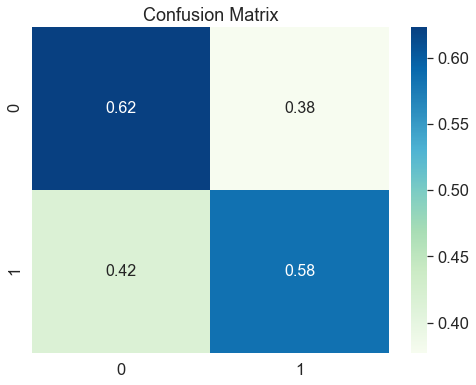

In [78]:
cm_array = [[TP/(TP+FN),FN/(TP+FN)],
            [FP/(FP+TN),TN/(FP+TN)]]        
df_cm = pd.DataFrame(cm_array, (0,1),(0,1))
plt.figure(figsize = (8,6))
sn.set(font_scale=1.5)#for label size
sn.heatmap(df_cm, cmap='GnBu',annot=True,annot_kws={"size": 16})# font size
plt.title('Confusion Matrix')
plt.show()

<h3>Plotting ROC and P-R Curves</h3>

In [79]:
import handyspark

In [80]:
bcm = handyspark.BinaryClassificationMetrics(prediction_results, scoreCol='probability',labelCol='label',)

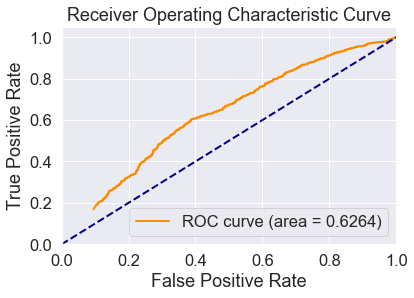

In [81]:
bcm.plot_roc_curve()

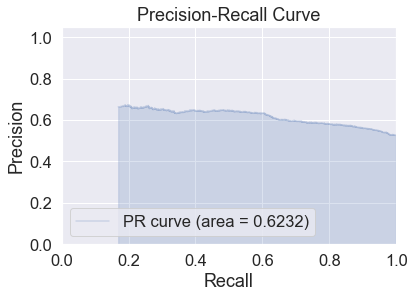

In [82]:
bcm.plot_pr_curve()

In [ ]:
spark.stop()

<h2>Evaluation results:</h2>

<li style="font-size:18px">The model accuracy is 60% which is reasonably good considering the usage of internet slang while writing the review for a product</li><br><li style="font-size:18px">The ROC curve being closer to the leading diagonal in the plot denotes that the model fares just better than a random classifier</li><br><li style="font-size:18px">This model can perform better with more amount of training data</li><br><li style="font-size:18px">Applying other NLP techniques like stemming might improve the model performance further</li>